# Model Training and Evaluation (Cambodia)

In [31]:
import os
import sys
sys.path.append("../../../")

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from geowrangler import dhs
from povertymapping import settings, osm, ookla, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.osm import OsmDataManager
from povertymapping.ookla import OoklaDataManager
import getpass
import pickle

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [32]:
%reload_ext autoreload
%autoreload 2

## Load Target Country From DHS data

In [33]:
# Set country-specific variables
country_osm = "cambodia"
ookla_year = 2019
nightlights_year = 2014

In [34]:
dhs_household_dta_path = settings.DATA_DIR/"dhs/kh/KHHR73DT/KHHR73FL.DTA"
dhs_geographic_shp_path = settings.DATA_DIR/"dhs/kh/KHGE71FL/KHGE71FL.shp"
dhs_gdf = generate_dhs_cluster_level_data(
    dhs_household_dta_path, 
    dhs_geographic_shp_path, 
    col_rename_config="kh",
    convert_geoms_to_bbox=True
).reset_index(drop=True)
dhs_gdf.explore()

In [35]:
dhs_gdf.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-7443.192308,KH201400000001,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1.0,banteay mean chey,CEN,R,13.518676,103.028394,9999.0,11.0,WGS84,"POLYGON ((103.01914 13.52767, 103.03764 13.527..."
1,2,2622.678571,KH201400000002,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1.0,banteay mean chey,CEN,R,13.398398,102.953852,9999.0,23.0,WGS84,"POLYGON ((102.94461 13.40739, 102.96310 13.407..."
2,3,22167.920000,KH201400000003,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1.0,banteay mean chey,CEN,R,13.503451,102.996001,9999.0,13.0,WGS84,"POLYGON ((102.98675 13.51244, 103.00525 13.512..."
3,4,32241.826087,KH201400000004,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1.0,banteay mean chey,CEN,U,13.549399,103.071416,9999.0,14.0,WGS84,"POLYGON ((103.06217 13.55839, 103.08067 13.558..."
4,5,154111.500000,KH201400000005,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1.0,banteay mean chey,CEN,U,13.538865,103.028993,9999.0,15.0,WGS84,"POLYGON ((103.01974 13.54786, 103.03824 13.547..."


## Set up Data Access

In [36]:
# Instantiate data managers for Ookla and OSM
# This auto-caches requested data in RAM, so next fetches of the data are faster.
osm_data_manager = OsmDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
ookla_data_manager = OoklaDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")

In [37]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-01-17 15:51:42.230 | INFO     | povertymapping.nightlights:get_eog_access_token:47 - Saving access_token to ~/.eog_creds/eog_access_token
2023-01-17 15:51:42.232 | INFO     | povertymapping.nightlights:get_eog_access_token:55 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Generate Base Features

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the ff. datasets from the internet. 

- OpenStreetMap Data from Geofabrik
- Ookla Internet Speed Data
- VIIRS nighttime lights data from NASA EOG

On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [38]:
%%time
country_data = dhs_gdf.copy()

# Add in OSM features
country_data = osm.add_osm_poi_features(country_data, country_osm, osm_data_manager)
country_data = osm.add_osm_road_features(country_data, country_osm, osm_data_manager)

# Add in Ookla features
country_data = ookla.add_ookla_features(country_data, 'fixed', ookla_year, ookla_data_manager)
country_data = ookla.add_ookla_features(country_data, 'mobile', ookla_year, ookla_data_manager)

# Add in the nighttime lights features
country_data = nightlights.generate_nightlights_feature(country_data, str(nightlights_year)) 


2023-01-17 15:51:42.465 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for cambodia at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/data/data_cache/osm/cambodia? True
2023-01-17 15:51:42.466 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for cambodia being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/data/data_cache/osm/cambodia/gis_osm_pois_free_1.shp
2023-01-17 15:51:45.194 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for cambodia at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/data/data_cache/osm/cambodia? True
2023-01-17 15:51:45.195 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for cambodia being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/data/data_cache/osm/cambodia/gis_osm_roads_free_1.shp
2023-01-17 15:51:55.633 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []

CPU times: user 15.2 s, sys: 155 ms, total: 15.4 s
Wall time: 15.4 s


### Inspect the combined target country data

In [39]:
country_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 611 entries, 0 to 610
Data columns (total 83 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DHSCLUST                           611 non-null    int64   
 1   Wealth Index                       611 non-null    float64 
 2   DHSID                              611 non-null    object  
 3   DHSCC                              611 non-null    object  
 4   DHSYEAR                            611 non-null    float64 
 5   CCFIPS                             611 non-null    object  
 6   ADM1FIPS                           611 non-null    object  
 7   ADM1FIPSNA                         611 non-null    object  
 8   ADM1SALBNA                         611 non-null    object  
 9   ADM1SALBCO                         611 non-null    object  
 10  ADM1DHS                            611 non-null    float64 
 11  ADM1NAME                           61

In [40]:
country_data.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,mobile_2019_mean_avg_d_kbps_mean,mobile_2019_mean_avg_u_kbps_mean,mobile_2019_mean_avg_lat_ms_mean,mobile_2019_mean_num_tests_mean,mobile_2019_mean_num_devices_mean,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,1,-7443.192308,KH201400000001,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1386.609599,608.081055,6.043991,0.104207,0.069471,-0.040154,0.107874,0.013407,0.037422,0.000646
1,2,2622.678571,KH201400000002,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,NaN,NaN,NaN,NaN,NaN,-0.057494,0.001848,-0.034930,0.015681,-0.040567
2,3,22167.920000,KH201400000003,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,166.033492,201.303045,4.173218,0.063575,0.054327,-0.051005,0.019071,-0.022702,0.019773,-0.022897
3,4,32241.826087,KH201400000004,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,163.544993,159.446459,5.115566,0.112354,0.078216,-0.029992,0.018604,-0.008490,0.015436,-0.010652
4,5,154111.500000,KH201400000005,KH,2014.0,CB,NULL,NULL,NULL,NULL,...,1026.349735,705.070491,4.372975,0.288528,0.161859,-0.013423,0.641859,0.235261,0.180695,0.180403


## Data Preparation

### Split into labels and features

In [41]:
# Set parameters
label_col = 'Wealth Index'

In [42]:
# Split train/test data into features and labels

# For labels, we just select the target label column
labels = country_data[[label_col]]

# For features, drop all columns from the input country geometries
# If you need the cluster data, refer to country_data / country_test
input_dhs_cols = dhs_gdf.columns
features = country_data.drop(input_dhs_cols, axis=1)

features.shape, labels.shape

((611, 61), (611, 1))

In [43]:
# Clean features
# For now, just impute nans with 0
# TODO: Implement other cleaning steps
features = features.fillna(0)


### Base Features List

The features can be subdivided by the source dataset

#### OSM
- `<poi type>_count`: number of points of interest (POI) of a specified type in that area
    - ex. atm_count: number of atms in cluster
    - poi_count: number of all POIs *of all types* in cluster 
- `<poi_type>_nearest`: distance of nearest POI of the specified type
    - ex. atm_nearest: distance of nearest ATM from that cluster
- OSM POI types included: `atm`, `bank`, `bus_stations`, `cafe`, `charging_station`, `courthouse`, `dentist` (clinic), `fast_food`, `fire_station`, `food_court`, `fuel` (gas station), `hospital`, `library`, `marketplace`, `pharmacy`, `police`, `post_box`, `post_office`, `restaurant`, `social_facility`, `supermarket`, `townhall`, `road`

#### Ookla 
The network metrics features follow the following name convention:

> `<type>_<year>_<yearly aggregate>_<network variable>_<cluster aggregate>`

- type: kind of network connection measured
    - fixed: connection from fixed sources (landline, fiber, etc.)
    - mobile: connection from mobile devices
- year: Year of source data
- yearly aggregate: How data was aggregated into yearly data
    - Note: Ookla provides data per quarter, so a yearly mean takes the average across 4 quarters
    - For this model, we only aggregate by yearly mean
- network variable: network characteristic described
    - avg_d_kbps: average download speed in kbps
    - avg_u_kbps: average upload speed in kbps
    - avg_lat_ms: average latency in ms
    - num_devices: number of devices measured
- cluster aggregate: how the data was aggregated per cluster aggregate
    - Types: min, mean, max, median, std.
        - For this model: only mean is used 
    - This is calculated using area zonal stats, which weighs the average by the intersection of the Ookla tile with the cluster geometry.
    
    
Ex. `fixed_2019_mean_avg_d_kbps_median` takes the cluster median of 2019 yearly average download speed.


#### Nightlights (VIIRS)
All nightlights features are taken as the zonal aggregate of the raster data per cluster

- ex. `avg_rad_mean`: cluster mean of the average radiance 
- aggregations used: min, mean, max, median


In [44]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 611 entries, 0 to 610
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   poi_count                          611 non-null    float64
 1   atm_count                          611 non-null    float64
 2   atm_nearest                        611 non-null    float64
 3   bank_count                         611 non-null    float64
 4   bank_nearest                       611 non-null    float64
 5   bus_station_count                  611 non-null    float64
 6   bus_station_nearest                611 non-null    float64
 7   cafe_count                         611 non-null    float64
 8   cafe_nearest                       611 non-null    float64
 9   charging_station_count             611 non-null    float64
 10  charging_station_nearest           611 non-null    float64
 11  courthouse_count                   611 non-null   

## Model Training

In [45]:
# Set parameters
cv_col = 'ADM1NAME'
cv_num_splits = 5
cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [46]:
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, test_size=test_size, random_state=train_test_seed
# )

# Cross validation
print(f"Performing {cv_num_splits}-fold CV...")
cv = RepeatedKFold(n_splits=cv_num_splits, n_repeats=cv_num_repeats, random_state=train_test_seed)

print(cv.split(features))


Performing 5-fold CV...
<generator object _RepeatedSplits.split at 0x7f12c2563580>


### Instantiate model
For now, we will train a simple random forest model

In [47]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2
- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

In [48]:
R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv)
print("Cross validation scores are: ", R_cv)
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.76571779 0.52933658 0.61593448 0.77196439 0.74892378 0.7182989
 0.66927124 0.69618357 0.60772753 0.77683086 0.752266   0.74428828
 0.71892056 0.68785755 0.68823922 0.70270511 0.79749037 0.65387869
 0.65956989 0.71061171 0.6529704  0.65475382 0.74182746 0.71644556
 0.75227853]
Cross validation R^2 mean: 0.7
Cross validation R^2 std: 0.06


### Train the final model

For training the final model, we train on all the available data.

In [50]:
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

## Model Evaluation

### Evaluation functions
Borrowed from https://colab.research.google.com/drive/1RmQwqyvrk7zpmldtdfKK_e_8oOARLJTE

**TODO**: Integrate into a model_utils module

### SHAP Feature Importance

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

In [56]:
shap_values

array([[-8.16727264e+02,  6.92386421e+00,  3.69259889e+02, ...,
        -8.65634524e+03, -5.28515291e+02, -1.56288604e+04],
       [-5.80440086e+02,  1.44657185e+00, -1.34460034e+03, ...,
        -9.14516789e+03,  8.47324328e+02, -1.58354930e+04],
       [-4.08496036e+02,  1.02384132e+01, -3.66868740e+02, ...,
        -9.57977340e+03,  1.60515012e+02, -1.85242383e+04],
       ...,
       [-7.15584424e+02,  5.36269463e+00,  7.71150303e+03, ...,
        -1.13396834e+04, -5.39779781e+03, -1.85251647e+04],
       [-6.33645584e+02,  6.43929186e-01, -2.26501904e+03, ...,
        -6.99410451e+03, -6.38746158e+01, -2.28240756e+04],
       [-6.37966365e+02,  1.26588987e+00, -1.68792306e+03, ...,
        -1.40313852e+04, -4.37507921e+03, -2.55547254e+04]])

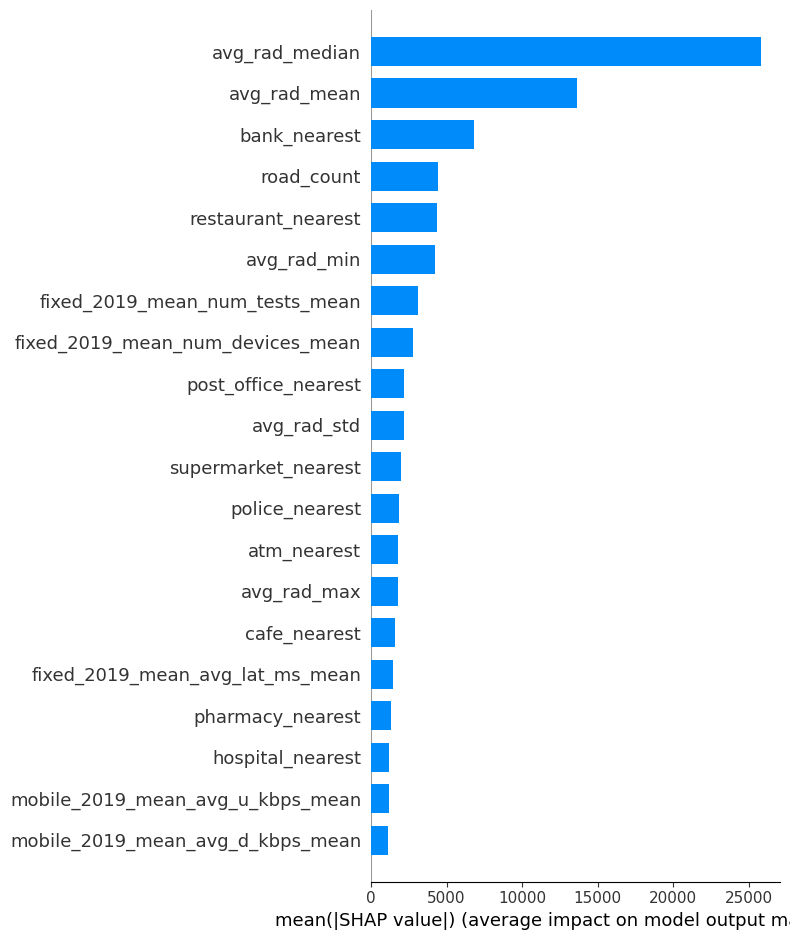

In [57]:
shap.summary_plot(shap_values, features, feature_names=features.columns, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


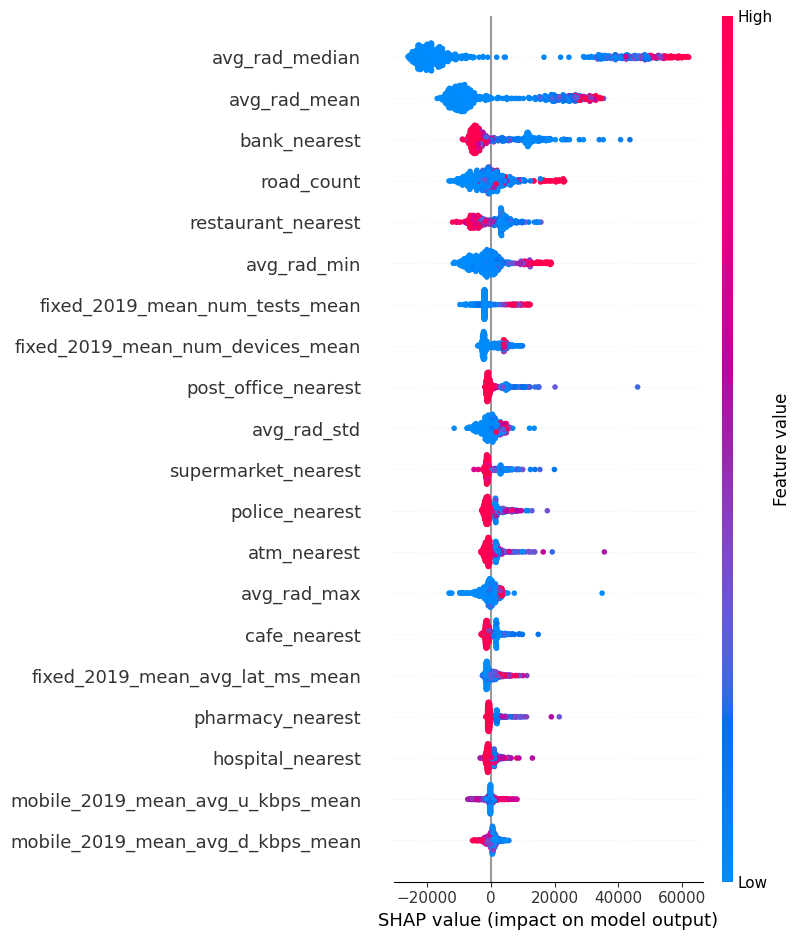

In [58]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)

## Save Model

In [59]:
model_save_path = "./model_kh.pkl"
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)